# Aplikasi Analisis Sentimen IMDB Berbasis Web dengan Streamlit

## Siane Santoso
## A11.2022.13956

### Ringkasan Masalah

    Di masa sekarang ini, ada banyak ulasan film yang ditulis oleh pengguna di platform seperti IMDb. Ini dapat menyebabkan analisis manual terhadap sentimen setiap ulasan menjadi sangat sulit dilakukan. Maka dari itu, diperlukan solusi yang lebih efisien untuk mengklasifikasikan sentimen dari ulasan-ulasan tersebut, dengan menggunakan sistem yang dapat mengotomatisasi proses analisis sentimen untuk memahami apakah ulasan yang diberikan cenderung positif atau negatif. Tantangan utamanya adalah bagaimana agar identifikasi sentimen yang terkandung dalam teks ulasan yang beragam dan panjang menjadi akurat dalam menentukan apakah ulasan tersebut bersifat positif atau negatif.

### Tujuan 

    Tujuan saya membuat project aplikasi berbasis Streamlit ini adalah untuk menyediakan sebuah platform yang lebih interaktif dan mudah diakses bagi pengguna untuk dapat melakukan analisis sentimen pada ulasan film di IMDb. Aplikasi ini akan menggunakan model pembelajaran mesin untuk mengkategorikan ulasan sebagai positif atau negatif berdasarkan isi teksnya. Dengan demikian, aplikasi ini bertujuan untuk memberikan alat yang mudah digunakan dalam mendeteksi sentimen yang ada pada ulasan film, yang dapat membantu pembuat film, pemasar, serta penonton dalam memahami reaksi publik terhadap suatu film.

### Bagan Alur Model 

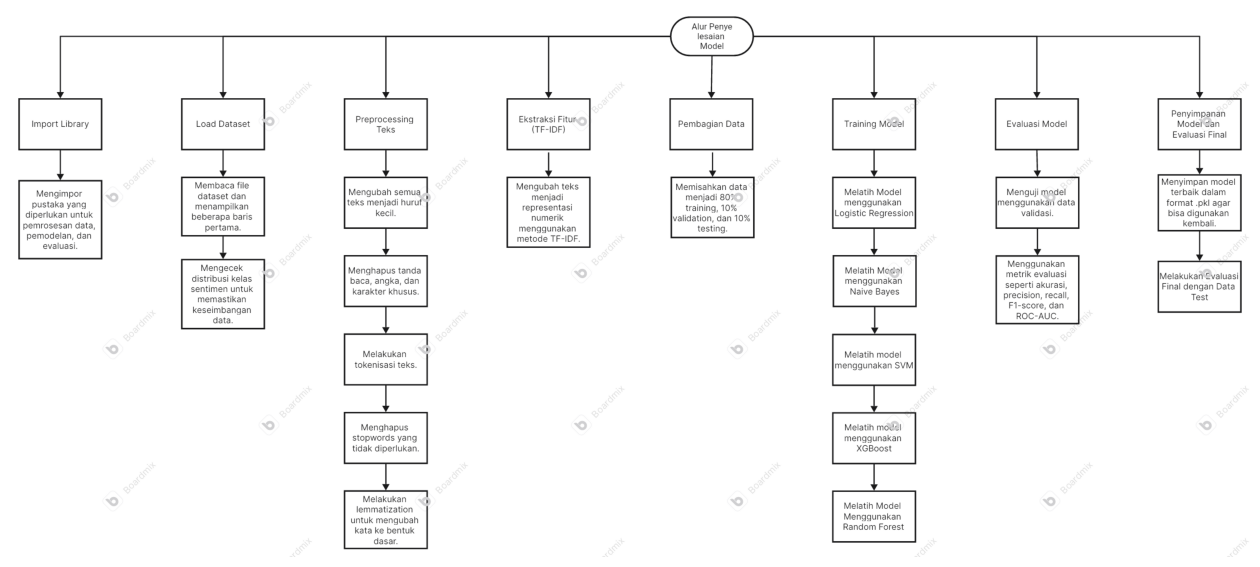

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('flowchart.png') 

# Mengatur ukuran gambar
plt.figure(figsize=(16, 11))  


plt.imshow(img)
plt.axis('off')  
plt.show()

### Penjelasan Dataset

    Dataset yang saya gunakan dalam proyek ini berasal dari kaggle, dengan nama dataset IMDB Dataset.csv, yang berisi ulasan film dari pengguna IMDb dengan label sentimen positif dan negatif. Dataset ini total memiliki 50.000 baris dengan dua kolom utama di dalamnya, yaitu :
1. Review: Berisi teks ulasan film dalam bahasa Inggris, dalam bentuk paragraf
2. Sentiment: Label kelas yang menunjukkan ulasan tersebut bersifat positif atau negatif.

In [7]:
# import library
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

import pickle

In [8]:
# Load dataset
df = pd.read_csv('IMDB Dataset.csv')

### Eksplorasi EDA

Pada tahap ini saya melakukan eksplorasi EDA untuk memahami struktur dataset, distribusi data, serta karakteristik teks sebelum proses pemodelan.
Langkah-langkah yang dilakukan disini, yakni :
1. Melihat distribusi kelas sentimen untuk mengecek keseimbangan data.
2. Menampilkan beberapa bais ulasan untuk memahami struktur teks sebelum preprocessing.

In [10]:
# lihat beberapa baris dataset
print(df.head())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [11]:
# periksa keseimbangan data 
df["sentiment"].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

### Proses Features Dataset

    Dalam tahap ini, yang saya lakukan adalah mengubah teks dalam dataset untuk menjadi representasi numerik agar dapat diproses oleh model nantinya. Dengan beberapa proses, yakni :
- Preprocessing Teks : Mengubah teks menjadi lowercase (Semua teks diubah menjadi huruf kecil untuk menghindari duplikasi kata yang hanya berbeda dalam kapitalisasi), Menghapus tanda baca, angka, dan karakter khusus(Tanda baca, angka, dan karakter khusus yang tidak relevan dihapus agar fokus hanya pada kata-kata), Tokenisasi untuk memecah teks menjadi kata-kata (Proses ini memecah teks menjadi kata-kata individual (token)), Menghapus stopwords yang tidak memberikan informasi penting(Penghapusan stopwords membantu untuk meningkatkan kualitas fitur teks), Melakukan lemmatization untuk mengubah kata ke bentuk dasarnya.
- Ekstraksi Fitur (TF-IDF) : Menggunakan TF-IDF (Term Frequency-Inverse Document Frequency) untuk mengubah teks menjadi vektor numerik yang dapat digunakan oleh model.TF mengukur seberapa sering kata muncul dalam dokumen, sedangkan IDF memberikan bobot berdasarkan seberapa jarang kata tersebut muncul di seluruh dataset. Vektor numerik yang dihasilkan bisa digunakan oleh model machine learning.
- Pembagian Dataset (80:10:10) : 80% Data Training untuk melatih model, 10% Data Validation untuk mengevaluasi performa selama training, 10% Data Testing untuk mengukur kinerja model di data baru.

In [13]:
# konversi huruf ke lowercase
df['review'] = df['review'].str.lower()

In [14]:
# Hapus tanda baca, angka, dan karakter khusus
df['review'] = df['review'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', ' ', x))

In [15]:
# Tokenisasi teks : Memecah teks menjadi kata-kata individu
df['review'] = df['review'].apply(word_tokenize)

In [16]:
# Hilangkan kata-kata tidak bermakna (stopwords)
stop_words = set(stopwords.words('english'))
df['review'] = df['review'].apply(lambda x: [word for word in x if word not in stop_words])

In [17]:
# Menghapus kata 'br' dari setiap tokenized review
df['review'] = df['review'].apply(lambda review: [word for word in review if word != 'br'])

In [18]:
# Lemmatization: Mengubah kata ke bentuk dasar

# Fungsi untuk mendapatkan POS tag untuk WordNet
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun

# Membuat objek lemmatizer dari WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Fungsi untuk lemmatize setiap review
df['review'] = df['review'].apply(lambda x: [
    lemmatizer.lemmatize(word, pos=get_wordnet_pos(tag)) for word, tag in pos_tag(x)
])

In [19]:
# Menggunakan TfidfVectorizer untuk mengubah teks menjadi fitur berbasis TF-IDF
tfidf = TfidfVectorizer(max_features=5000)

# Melakukan transformasi data teks menjadi representasi vektor
X = tfidf.fit_transform(df['review'].astype(str)).toarray()  

# Mengonversi label sentimen menjadi 1 untuk positif dan 0 untuk negatif
y = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

In [20]:
# Split data Menjadi Training, Val, Dan Test (80 : 10 : 10)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

### Proses Learning Model 

    Pada tahap ini saya melakukan Proses Learning / Modeling menggunakan beberapa model machine learning melakukan klasifikasi terhadap data yang telah dipersiapkan. Model-model yang digunakan antara lain Logistic Regression, Naive Bayes (MultinomialNB), Support Vector Machine (SVM - LinearSVC), XGBoost Classifier, dan Random Forest Classifier. Masing-masing model ini dipilih karena memiliki karakteristik yang berbeda dalam menangani data dengan fitur dan struktur yang beragam.

    Di Proses selanjutnya, saya melakukan Evaluasi Model. Model-model yang telah dilatih menggunakan data training akan diuji dengan data validasi untuk menilai kinerjanya. Berbagai metrik evaluasi digunakan untuk mengukur performa model, antara lain Akurasi, Precision, Recall, F1-score, ROC-AUC, dan Confusion Matrix untuk memberikan gambaran yang komprehensif tentang seberapa baik model dapat mengklasifikasikan data sesuai dengan label yang sebenarnya, baik dalam hal prediksi positif maupun negatif.

    Setelah evaluasi menggunakan data validasi dilakukan, model terbaik yang menunjukkan kinerja optimal diuji kembali menggunakan data testing sebagai evaluasi final untuk memastikan bahwa model tersebut dapat menggeneralisasi dengan baik terhadap data yang belum pernah dilihat sebelumnya. 

    Pada langkah yang terakhir, Penyimpanan Model dilakukan dengan menyimpan model terbaik dalam format .pkl menggunakan fungsi pickle.dump(). Dengan demikian, model yang sudah dilatih dan teruji dapat digunakan kembali di masa depan tanpa perlu dilatih ulang

In [22]:
# Latih Model Dengan Logistic Regression
modelLR = LogisticRegression()
modelLR.fit(X_train, y_train)

LogisticRegression()

In [23]:
# Latih Model Dengan Naive Bayes
modelNB = MultinomialNB()
modelNB.fit(X_train, y_train)

MultinomialNB()

In [24]:
# Latih Model Dengan Random Forest
modelRF = RandomForestClassifier()
modelRF.fit(X_train, y_train)

RandomForestClassifier()

In [25]:
# Latih Model Dengan Linear SVC
modelLSVC = LinearSVC()
modelLSVC.fit(X_train, y_train)

LinearSVC()

In [26]:
# Latih Model Dengan XGBoost Classifier
modelXGB = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
modelXGB.fit(X_train, y_train)

C:\Users\ASUS\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:19:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

### Performa Model

    Di tahap ini, saya melakukan evaluasi menggunakan model-model machine learning yang sudah saya latih sebekumnya melalui data validasi. Model Logistic Regression menunjukkan performa terbaik dengan akurasi validasi sebesar 88.84%. ROC-AUC untuk model ini mencapai 93.54%, menunjukkan kemampuan yang sangat baik dalam membedakan antara kelas positif dan negatif. Laporan klasifikasinya menunjukkan F1-score sebesar 0.89 untuk kedua kelas, dengan confusion matrix yang menunjukkan 2171 true positives, 2271 true negatives, 329 false positives, dan 229 false negatives.

    Model Multinomial Naive Bayes menghasilkan akurasi validasi sebesar 85.22% dengan ROC-AUC 93.54%. F1-score untuk kedua kelas adalah 0.85, yang menunjukkan performa yang konsisten meskipun lebih rendah dibanding Logistic Regression. Confusion matrix menunjukkan 2087 true positives, 2174 true negatives, 413 false positives, dan 326 false negatives.

    Model Random Forest memiliki akurasi validasi sebesar 84.96% dengan ROC-AUC yang serupa. Precision dan recall untuk kedua kelas adalah 0.85, menghasilkan F1-score yang sama. Performa ini sedikit di bawah Multinomial Naive Bayes dan Logistic Regression.

    Model Linear SVC memberikan hasil yang hampir setara dengan Logistic Regression, dengan akurasi validasi sebesar 88.52% dan ROC-AUC sebesar 93.54%. F1-score untuk kedua kelas yang hampir sama yakni, adalah 0.88 untuk kelas 0 dan 0.89 untuk kelas 1, menunjukkan keseimbangan yang baik dalam mendeteksi kelas positif maupun negatif.
    
    Model XGBoost menghasilkan akurasi validasi sebesar 85.46% dan ROC-AUC sebesar 93.54%. F1-score untuk kelas 0 adalah 0.85 dan untuk kelas 1 adalah 0.86. Meskipun performa model ini cukup baik, model ini tidak melampaui Logistic Regression dan Linear SVC.

In [28]:
# Evaluasi pada data validasi menggunakan model logistic regression
print("Evaluasi pada Data Validasi Menggunakan model Logistic Regression:")
y_val_pred = modelLR.predict(X_val)
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred)}")
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

# Menampilkan confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

# Menghitung AUC-ROC
y_val_prob = modelXGB.predict_proba(X_val)[:, 1]  # mengukur kemampuan model untuk memisahkan kedua kelas (positif dan negatif)
auc_score = roc_auc_score(y_val, y_val_prob)
print(f"Validation AUC-ROC: {auc_score}")

Evaluasi pada Data Validasi Menggunakan model Logistic Regression:
Validation Accuracy: 0.8884
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      2500
           1       0.87      0.91      0.89      2500

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000

Confusion Matrix:
[[2171  329]
 [ 229 2271]]
Validation AUC-ROC: 0.9353724


In [29]:
# Evaluasi pada data validasi menggunakan model naive bayes
print("Evaluasi pada Data Validasi menggunakan naive bayes :")
y_val_pred = modelNB.predict(X_val)
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred)}")
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

# Menampilkan confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

# Menghitung AUC-ROC
y_val_prob = modelXGB.predict_proba(X_val)[:, 1]  # mengukur kemampuan model untuk memisahkan kedua kelas (positif dan negatif)
auc_score = roc_auc_score(y_val, y_val_prob)
print(f"Validation AUC-ROC: {auc_score}")

Evaluasi pada Data Validasi menggunakan naive bayes :
Validation Accuracy: 0.8522
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.83      0.85      2500
           1       0.84      0.87      0.85      2500

    accuracy                           0.85      5000
   macro avg       0.85      0.85      0.85      5000
weighted avg       0.85      0.85      0.85      5000

Confusion Matrix:
[[2087  413]
 [ 326 2174]]
Validation AUC-ROC: 0.9353724


In [30]:
# Evaluasi pada data validasi dengan Model Random Forest
print("Evaluasi pada Data Validasi menggunakan random forest:")
y_val_pred = modelRF.predict(X_val)
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred)}")
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

# Menampilkan confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

# Menghitung AUC-ROC
y_val_prob = modelXGB.predict_proba(X_val)[:, 1]  # mengukur kemampuan model untuk memisahkan kedua kelas (positif dan negatif)
auc_score = roc_auc_score(y_val, y_val_prob)
print(f"Validation AUC-ROC: {auc_score}")

Evaluasi pada Data Validasi menggunakan random forest:
Validation Accuracy: 0.8496
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      2500
           1       0.85      0.84      0.85      2500

    accuracy                           0.85      5000
   macro avg       0.85      0.85      0.85      5000
weighted avg       0.85      0.85      0.85      5000

Confusion Matrix:
[[2138  362]
 [ 390 2110]]
Validation AUC-ROC: 0.9353724


In [31]:
# Evaluasi pada data validasi dengan Model Linear SVC
print("Evaluasi pada Data Validasi menggunakan linear svc:")
y_val_pred = modelLSVC.predict(X_val)
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred)}")
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

# Menampilkan confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

# Menghitung AUC-ROC
y_val_prob = modelXGB.predict_proba(X_val)[:, 1]  # mengukur kemampuan model untuk memisahkan kedua kelas (positif dan negatif)
auc_score = roc_auc_score(y_val, y_val_prob)
print(f"Validation AUC-ROC: {auc_score}")

Evaluasi pada Data Validasi menggunakan linear svc:
Validation Accuracy: 0.8852
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.88      2500
           1       0.87      0.90      0.89      2500

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000

Confusion Matrix:
[[2178  322]
 [ 252 2248]]
Validation AUC-ROC: 0.9353724


In [32]:
# Evaluasi pada data validasi dengan Model XGBoost
print("Evaluasi pada Data Validasi menggunakan XGBoost:")
y_val_pred = modelXGB.predict(X_val)
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred)}")
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

# Menampilkan confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

# Menghitung AUC-ROC
y_val_prob = modelXGB.predict_proba(X_val)[:, 1]  # mengukur kemampuan model untuk memisahkan kedua kelas (positif dan negatif)
auc_score = roc_auc_score(y_val, y_val_prob)
print(f"Validation AUC-ROC: {auc_score}")

Evaluasi pada Data Validasi menggunakan XGBoost:
Validation Accuracy: 0.8546
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      2500
           1       0.84      0.88      0.86      2500

    accuracy                           0.85      5000
   macro avg       0.86      0.85      0.85      5000
weighted avg       0.86      0.85      0.85      5000

Confusion Matrix:
[[2085  415]
 [ 312 2188]]
Validation AUC-ROC: 0.9353724


### Model Terbaik 

    Di tahap ini saya melakukan pemilihan model terbaik dan berdasarkan hasil evaluasi, model Logistic Regression dipilih sebagai model terbaik karena memiliki akurasi validasi tertinggi, yaitu 88.84%. Selain itu, model ini juga menunjukkan hasil yang konsisten pada metrik lain seperti ROC-AUC, precision, recall, dan F1-score. Model Logistic Regression disimpan bersama dengan TF-IDF Vectorizer untuk digunakan pada evaluasi akhir.

In [ ]:
# Daftar model
models = [
    ('naive_bayes', modelNB),
    ('linear_regression', modelLR),
    ('random_forest', modelRF),
    ('linear_svc', modelLSVC),
    ('xgboost_classifier', modelXGB)
]

# Inisialisasi dictionary untuk menyimpan akurasi
accuracy_scores = {}

# Hitung akurasi untuk setiap model
for name, model in models:
    # Prediksi dengan model
    y_pred = model.predict(X_test)
    
    # Hitung akurasi prediksi
    accuracy = accuracy_score(y_test, y_pred)
    
    # Simpan skor akurasi
    accuracy_scores[name] = accuracy

# Menampilkan skor akurasi untuk setiap model
print("Accuracy scores for each model:")
for model_name, accuracy in accuracy_scores.items():
    print(f"{model_name}: {accuracy}")

# Pilih model dengan akurasi tertinggi
best_model = max(accuracy_scores, key=accuracy_scores.get)
print(f"\nModel terbaik berdasarkan akurasi prediksi adalah: {best_model}")

In [34]:
# Simpan TfidfVectorizer
with open('vectorizer.pkl', 'wb') as file:
    pickle.dump(tfidf, file)

# Simpan model terbaik yaitu linear regression
with open('sentiment_model.pkl', 'wb') as file:
    pickle.dump(modelLR, file)

print("Vectorizer dan model berhasil disimpan.")

Vectorizer dan model berhasil disimpan.


In [35]:
# Muat TfidfVectorizer
with open('vectorizer.pkl', 'rb') as file:
    tfidf = pickle.load(file)

# Muat model
with open('sentiment_model.pkl', 'rb') as file:
    sentiment_model = pickle.load(file)

print("Vectorizer dan model berhasil dimuat.")

Vectorizer dan model berhasil dimuat.


### Evaluasi Final Menggunakan Data Test

    Di tahap Evaluasi akhir ini dilakukan menggunakan model Logistic Regression yang sudah disimpan sebelumnya pada data test. Akurasi test tercatat sebesar 88.48%, yang menunjukkan konsistensi performa dengan data validasi. ROC-AUC mencapai 95.49%, menunjukkan kemampuan model yang sangat baik dalam membedakan antara kelas. Laporan klasifikasi menunjukkan F1-score sebesar 0.88 untuk kelas negatif dan 0.89 untuk kelas positif. Confusion matrix mencatat 2206 true positives, 2218 true negatives, 294 false positives, dan 282 false negatives, menandakan generalisasi model yang baik terhadap data baru.

In [36]:
# Evaluasi Final pada data test 
print("Evaluasi pada Data Test :")
y_test_pred =sentiment_model.predict(X_test)

print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred)}")
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

# Menampilkan confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

# Menghitung AUC-ROC
y_test_prob = sentiment_model.predict_proba(X_test)[:, 1]  # mengukur kemampuan model untuk memisahkan kedua kelas (positif dan negatif)
auc_score = roc_auc_score(y_test, y_test_prob)
print(f"Validation AUC-ROC: {auc_score}")

Evaluasi pada Data Test :
Test Accuracy: 0.8848
Test Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      2500
           1       0.88      0.89      0.89      2500

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000

Confusion Matrix:
[[2206  294]
 [ 282 2218]]
Validation AUC-ROC: 0.95494816


### Diskusi Hasil dan Kesimpulan

    Kesimpulan dari projek kali ini, logistic Regression telah diidentifikasi sebagai model terbaik untuk tugas klasifikasi sentimen pada dataset IMDB berdasarkan akurasi validasi sebesar 88.84% dan akurasi test sebesar 88.48%. Meskipun model ini menunjukkan performa yang cukup baik dengan metrik seperti ROC-AUC dan F1-score yang tinggi, menurut saya hasil tersebut belum sepenuhnya optimal.

    Masih ada beberapa hal yang dapat dilakukan untuk meningkatkan performa model di masa yang akan mendatang meliputi optimasi hyperparameter, eksplorasi teknik representasi teks yang lebih canggih seperti Word2Vec atau pre-trained embeddings, dan penggunaan model berbasis deep learning seperti LSTM atau Transformer. Selain itu, eksperimen tambahan pada preprocessing teks dan evaluasi terhadap distribusi data dapat membantu meningkatkan kualitas prediksi.